In [62]:
# Importing all the required libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, log10, lit, count, when, sqrt, pow, percentile_approx
from pyspark.sql import functions as F
from pyspark.sql.window import Window
from pyspark.sql.functions import udf

from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import RandomForestClassifier, LogisticRegression
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.linalg import VectorUDT

import os

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from matplotlib import colors

In [ ]:
# ====================================================
# SETUP & LOAD
# ====================================================
# Initialise Spark session once
spark = SparkSession.builder \
    .appName("Gaia_HR_Analysis") \
    .config("spark.driver.memory", "4g") \
    .getOrCreate()

# Define Paths
survey_path = "../data/gaia_survey.parquet"
local_path = "../data/gaia_100pc.parquet"

# Load Datasets
print(">>> LOADING DATASETS...")
df_survey = spark.read.parquet(survey_path)
df_local = spark.read.parquet(local_path)

print(f"Dataset 1 (Survey/Macro): {df_survey.count():,} rows")
df_survey.printSchema()

print(f"Dataset 2 (Local/Micro):  {df_local.count():,} rows")
df_local.printSchema()

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/12/17 07:59:38 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


>>> LOADING DATASETS...


Dataset 1 (Survey/Macro): 844,868 rows
root
 |-- source_id: long (nullable = true)
 |-- ra: double (nullable = true)
 |-- dec: double (nullable = true)
 |-- parallax: double (nullable = true)
 |-- parallax_error: float (nullable = true)
 |-- pmra: double (nullable = true)
 |-- pmdec: double (nullable = true)
 |-- phot_g_mean_mag: float (nullable = true)
 |-- bp_rp: float (nullable = true)
 |-- teff_gspphot: float (nullable = true)

Dataset 2 (Local/Micro):  541,958 rows
root
 |-- source_id: long (nullable = true)
 |-- ra: double (nullable = true)
 |-- dec: double (nullable = true)
 |-- parallax: double (nullable = true)
 |-- parallax_error: float (nullable = true)
 |-- pmra: double (nullable = true)
 |-- pmdec: double (nullable = true)
 |-- phot_g_mean_mag: float (nullable = true)
 |-- bp_rp: float (nullable = true)
 |-- teff_gspphot: float (nullable = true)



In [4]:
df_survey.cache()
df_local.cache()
print("\n>>> DATAFRAMES CACHED IN MEMORY.")

df_survey.count()
df_local.count()
print(">>> CACHE ACTIONS COMPLETED.")


>>> DATAFRAMES CACHED IN MEMORY.


>>> CACHE ACTIONS COMPLETED.


Intermediate datasets were cached to optimise repeated analytical queries and reduce recomputation overhead.

In [ ]:
# ====================================================
# PHYSICAL COMPARISON (The "Two-Tier" Proof)
# ====================================================
# Survey = Distant, Local = Nearby.

print("\n>>> STATISTICAL COMPARISON: PARALLAX (Distance)")
print("Note: Distance (pc) is approx 1000 / parallax.")

print("-- Survey Dataset Stats --")
df_survey.select("bp_rp","phot_g_mean_mag","parallax").describe().show()

print("-- Local Bubble Stats --")
df_local.select("bp_rp","phot_g_mean_mag","parallax").describe().show()


>>> STATISTICAL COMPARISON: PARALLAX (Distance)
Note: Distance (pc) is approx 1000 / parallax.
-- Survey Dataset Stats --
+-------+------------------+------------------+--------------------+
|summary|             bp_rp|   phot_g_mean_mag|            parallax|
+-------+------------------+------------------+--------------------+
|  count|            821788|            844868|              844868|
|   mean|1.5300547396294117|17.404869147894882|   0.550712539924422|
| stddev|0.6075873126388563|1.4361723326971536|  0.7697707648724811|
|    min|       -0.54805183|         3.0238004|1.868718209532133E-7|
|    max|          7.822592|         18.999998|   75.56887569382528|
+-------+------------------+------------------+--------------------+

-- Local Bubble Stats --
+-------+------------------+------------------+------------------+
|summary|             bp_rp|   phot_g_mean_mag|          parallax|
+-------+------------------+------------------+------------------+
|  count|            473787| 

In [ ]:

# ====================================================
# QUALITY CHECK (Null Analysis)
# ====================================================
# Helper function to avoid repeating code
def report_nulls(df, columns):
    return df.select([count(when(col(c).isNull(), c)).alias(c) for c in columns])

cols_to_check = ["parallax", "phot_g_mean_mag", "teff_gspphot", "bp_rp"]

print("\n>>> NULL VALUE ANALYSIS (Survey Dataset)")
report_nulls(df_survey, cols_to_check).show()

print("\n>>> NULL VALUE ANALYSIS (Local Dataset)")
report_nulls(df_local, cols_to_check).show()


>>> NULL VALUE ANALYSIS (Survey Dataset)
+--------+---------------+------------+-----+
|parallax|phot_g_mean_mag|teff_gspphot|bp_rp|
+--------+---------------+------------+-----+
|       0|              0|      125194|23080|
+--------+---------------+------------+-----+


>>> NULL VALUE ANALYSIS (Local Dataset)
+--------+---------------+------------+-----+
|parallax|phot_g_mean_mag|teff_gspphot|bp_rp|
+--------+---------------+------------+-----+
|       0|           1099|      423880|68171|
+--------+---------------+------------+-----+



# Predict whether a star is Hot or Cool

Two supervised learning models were implemented to classify Gaia stars into hot and cool populations. Logistic Regression was used as a baseline linear classifier, while Random Forest was employed to capture non-linear relationships between stellar colour, brightness, and distance. The performance of both models was evaluated and compared using standard classification metrics.

## Model 1: Random Forest Classifier

Models will be trained using the local Gaia dataset (within 100 pc) to ensure reliable temperature estimates and clearer stellar population separation when classifying stars into hot and cool categories.

In [7]:
df_labeled = (
    df_local
    .filter(col("teff_gspphot").isNotNull())
    .withColumn(
        "label",
        when(col("teff_gspphot") <= 5200, 0).otherwise(1)
    )
)

A binary label was created to support supervised classification. Stars with an effective temperature (teff_gspphot) of ≤ 5200 K were classified as Cool (0), while stars with temperatures > 5200 K were classified as Hot (1). Rows with missing temperature values were removed to ensure valid model training. This threshold represents a physically meaningful division between cooler and hotter stellar populations and produces a label format compatible with Spark MLlib classifiers.

In [8]:
print("\n>>> LABEL DISTRIBUTION IN LABELED DATASET")
df_labeled.groupBy("label").count().show()


>>> LABEL DISTRIBUTION IN LABELED DATASET
+-----+-----+
|label|count|
+-----+-----+
|    1|25192|
|    0|92886|
+-----+-----+



The labeled dataset is imbalanced, with **92,886 stars (79%)** classified as *Cool* and **25,192 stars (21%)** classified as *Hot*. This imbalance reflects the physical reality of the local stellar population, where cooler, lower-mass stars are significantly more common than hot, massive stars. To address this class imbalance during model training, techniques such as class weighting or resampling can be applied to ensure the classifier learns to identify both classes effectively..

In [ ]:
# ----------------------------------------------------
# Select features and label
# ----------------------------------------------------
feature_cols = [
    "bp_rp",
    "phot_g_mean_mag",
    "parallax"
]

df_model = (
    df_labeled
    .select(feature_cols + ["label"])
    .dropna()
)

# ----------------------------------------------------
# Handle class imbalance using class weights
# ----------------------------------------------------
# Compute class counts
label_counts = df_model.groupBy("label").count().collect()
total = sum(row["count"] for row in label_counts)

weights = {
    row["label"]: total / (2 * row["count"])
    for row in label_counts
}

df_model = df_model.withColumn(
    "weight",
    when(col("label") == 0, weights[0]).otherwise(weights[1])
)

# ----------------------------------------------------
# Assemble feature vector
# ----------------------------------------------------
assembler = VectorAssembler(
    inputCols=feature_cols,
    outputCol="features"
)

df_model = assembler.transform(df_model).select(
    "features", "label", "weight"
)

df_model.show(5)


+--------------------+-----+------------------+
|            features|label|            weight|
+--------------------+-----+------------------+
|[1.34091758728027...|    0|0.6356085482047693|
|[0.71949863433837...|    1| 2.343541600508098|
|[2.72854232788085...|    0|0.6356085482047693|
|[2.83824539184570...|    0|0.6356085482047693|
|[1.20291805267333...|    0|0.6356085482047693|
+--------------------+-----+------------------+
only showing top 5 rows


The output confirms successful feature assembly and class weighting. Each row now contains a features vector combining the selected physical attributes (bp_rp, phot_g_mean_mag, and parallax), a binary class label, and an associated weight used during model training.

Stars in the majority class (Cool, label 0) are assigned a lower weight, while stars in the minority class (Hot, label 1) receive a higher weight. This weighting compensates for class imbalance by penalizing misclassification of the minority class more strongly, encouraging the model to learn meaningful decision boundaries for both stellar populations.

In [ ]:
#Split data into training and test sets
train_df, test_df = df_model.randomSplit([0.8, 0.2], seed=42)

#Define Random Forest Classifier
rf = RandomForestClassifier(
    labelCol="label",
    featuresCol="features",
    weightCol="weight",
    seed=42
)

# Build Parameter Grid for Hyperparameter Tuning


paramGrid = (
    ParamGridBuilder()
    .addGrid(rf.numTrees, [50, 100,])
    .addGrid(rf.maxDepth, [5, 8, 10])
    .build()
)

# Define Evaluator
evaluator = MulticlassClassificationEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="f1"
)

# Define CrossValidator
cv = CrossValidator(
    estimator=rf,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator,
    numFolds=3,
    parallelism=2
)

cv_model = cv.fit(train_df)
best_model = cv_model.bestModel

print("\n>>> BEST MODEL PARAMETERS")
print("Best numTrees:", best_model.getNumTrees)
print("Best maxDepth:", best_model.getMaxDepth())


25/12/17 08:00:06 WARN DAGScheduler: Broadcasting large task binary with size 1254.5 KiB
25/12/17 08:00:11 WARN DAGScheduler: Broadcasting large task binary with size 1254.4 KiB
25/12/17 08:00:11 WARN DAGScheduler: Broadcasting large task binary with size 1824.7 KiB
25/12/17 08:00:13 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
25/12/17 08:00:14 WARN DAGScheduler: Broadcasting large task binary with size 1007.8 KiB
25/12/17 08:00:21 WARN DAGScheduler: Broadcasting large task binary with size 1498.5 KiB
25/12/17 08:00:22 WARN DAGScheduler: Broadcasting large task binary with size 1498.6 KiB
25/12/17 08:00:23 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
25/12/17 08:00:25 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
25/12/17 08:00:27 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
25/12/17 08:00:27 WARN DAGScheduler: Broadcasting large task binary with size 1124.3 KiB
25/12/17 08:00:30 WARN DAGSchedul

Best numTrees: 100
Best maxDepth: 10


To ensure validation, the dataset was partitioned into an 80% training set and a 20% test set. A Random Forest classifier was then initialised, with the weightCol parameter explicitly linked to the previously calculated class weights; this was essential to prevent the model from biasing towards the majority class and ignoring the minority 'Hot' stars.

Model optimisation was conducted using a grid search to test different tree counts (50 and 100) and maximum depths (5, 8, and 10). Performance was evaluated via 3-fold cross-validation using the F1 score. The analysis confirmed that the optimal configuration consisted of 100 trees with a maximum depth of 10.

### Why f1_score?
Accuracy can be misleading for imbalanced datasets like ours (79% Cool stars, 21% Hot stars). A model that predicts mostly the majority class could achieve high accuracy while failing to identify the minority class. F1 score balances precision and recall, providing a more reliable measure of performance for both classes.

In [12]:
# Prediction on test set
predictions = best_model.transform(test_df)

# Compute F1 score
f1_score = evaluator.evaluate(predictions)
print(f"\n>>> TEST SET F1 SCORE: {f1_score:.4f}")


25/12/17 08:09:14 WARN DAGScheduler: Broadcasting large task binary with size 1972.2 KiB



>>> TEST SET F1 SCORE: 0.9842


The Random Forest classifier achieved a test F1 score of 0.984, demonstrating accuracy in distinguishing Hot and Cool stars, even with class imbalance.


>>> FEATURE IMPORTANCES:
bp_rp: 0.7163
phot_g_mean_mag: 0.2761
parallax: 0.0076


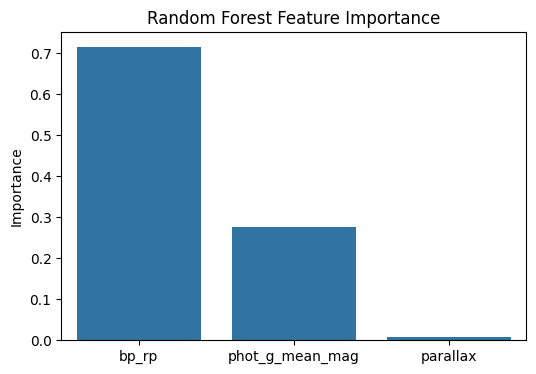

In [15]:
#Feature Importance:

importances = best_model.featureImportances
print("\n>>> FEATURE IMPORTANCES:")
for i, col_name in enumerate(feature_cols):
    print(f"{col_name}: {importances[i]:.4f}")

#Visualise Feature Importance
plt.figure(figsize=(6,4))
sns.barplot(x=feature_cols, y=importances.toArray())
plt.title("Random Forest Feature Importance")
plt.ylabel("Importance")
plt.show()

The Random Forest model relies primarily on the stellar color (bp_rp) to distinguish Hot and Cool stars, with magnitude providing additional, but smaller, contribution. Distance (parallax) has negligible influence in this local sample. This agrees with astrophysical expectations, as stellar temperature is closely linked to color.

25/12/17 08:15:22 WARN DAGScheduler: Broadcasting large task binary with size 1968.0 KiB
25/12/17 08:15:23 WARN DAGScheduler: Broadcasting large task binary with size 1933.5 KiB
25/12/17 08:15:23 WARN DAGScheduler: Broadcasting large task binary with size 1968.2 KiB


+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    0|       0.0|18395|
|    0|       1.0|  274|
|    1|       0.0|  102|
|    1|       1.0| 4890|
+-----+----------+-----+



25/12/17 08:15:24 WARN DAGScheduler: Broadcasting large task binary with size 1933.8 KiB
25/12/17 08:15:24 WARN DAGScheduler: Broadcasting large task binary with size 1933.7 KiB



>>> CONFUSION MATRIX:
prediction    0.0   1.0
label                  
0           18395   274
1             102  4890


25/12/17 08:15:24 WARN DAGScheduler: Broadcasting large task binary with size 1933.7 KiB


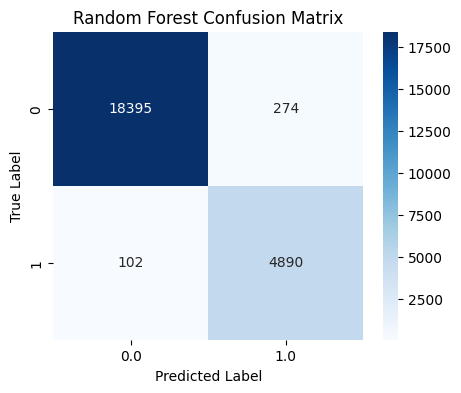

In [ ]:
conf_matrix = predictions.groupBy("label", "prediction").count().orderBy("label", "prediction")
conf_matrix.show()

# Optional: Convert to Pandas for nicer display/plot
conf_matrix_pd = conf_matrix.toPandas().pivot(index='label', columns='prediction', values='count').fillna(0)

print("\n>>> CONFUSION MATRIX:")
print(conf_matrix_pd)

# Plot confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(conf_matrix_pd, annot=True, fmt="g", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Random Forest Confusion Matrix")
plt.show()

### Confusion Matrix
* This matrix quantifies the accuracy seen in the plots above.

* True Positives (Hot stars correctly identified): 4,890

* True Negatives (Cool stars correctly identified): 18,395

* False Negatives (Hot stars missed): Only 102

* False Positives (Cool stars wrong): Only 274

The low number of off-diagonal errors confirms the model is highly accurate.

In [ ]:

# UDF to extract individual features from features vector
def get_feature(idx):
    return udf(lambda v: float(v[idx]), "double")

# Add original features back to predictions
pred_rf_plot = predictions \
    .withColumn("bp_rp", get_feature(0)("features")) \
    .withColumn("phot_g_mean_mag", get_feature(1)("features"))

# Original test data (true labels)
test_plot_df = test_df \
    .withColumn("bp_rp", get_feature(0)("features")) \
    .withColumn("phot_g_mean_mag", get_feature(1)("features"))

# Convert both to Pandas
pred_rf_pd = pred_rf_plot.select("bp_rp", "phot_g_mean_mag", "prediction").toPandas()
test_pd = test_plot_df.select("bp_rp", "phot_g_mean_mag", "label").toPandas()


25/12/17 09:25:51 WARN DAGScheduler: Broadcasting large task binary with size 1958.9 KiB


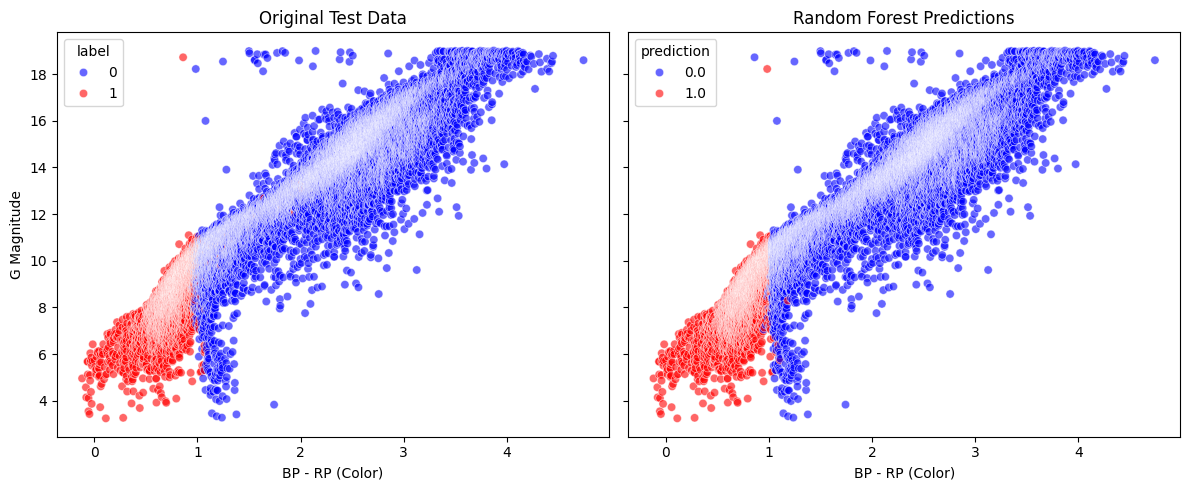

In [ ]:
# Plotting
fig, axes = plt.subplots(1, 2, figsize=(12,5), sharex=True, sharey=True)

# Original data
sns.scatterplot(
    ax=axes[0],
    data=test_pd,
    x="bp_rp",
    y="phot_g_mean_mag",
    hue="label",
    palette={0:"blue", 1:"red"},
    alpha=0.6
)
axes[0].invert_yaxis()
axes[0].set_title("Original Test Data")
axes[0].set_xlabel("BP - RP (Color)")
axes[0].set_ylabel("G Magnitude")

# Random Forest predictions
sns.scatterplot(
    ax=axes[1],
    data=pred_rf_pd,
    x="bp_rp",
    y="phot_g_mean_mag",
    hue="prediction",
    palette={0:"blue", 1:"red"},
    alpha=0.6
)
axes[1].invert_yaxis()
axes[1].set_title("Random Forest Predictions")
axes[1].set_xlabel("BP - RP (Color)")
axes[1].set_ylabel("G Magnitude")

plt.tight_layout()
plt.show()


### Predicted vs. Actual Scatter Plots

The scatter plots below compare the Ground Truth (Original Test Data) against the Random Forest Predictions.

* Left Plot (Original Data): Shows the true distribution of Hot (Red) and Cool (Blue) stars based on their physical properties.

* Right Plot (RF Predictions): Shows how the model classified them. You can see the model captured the distinct, non-linear boundary between the two populations almost perfectly, with very few visible errors.

## Model 2: Logistic Regression

In [ ]:
# ---------------------------------------------
# Logistic Regression setup
# ---------------------------------------------
lr = LogisticRegression(
    featuresCol="features",
    labelCol="label",
    weightCol="weight",   # keep same weighting as RF
    maxIter=100,
    regParam=0.01,
    elasticNetParam=0.0   # L2 regularization
)

# ---------------------------------------------
# Fit Logistic Regression on same training set
# ---------------------------------------------
lr_model = lr.fit(train_df)

# ---------------------------------------------
# Predict on the same test set
# ---------------------------------------------
predictions_lr = lr_model.transform(test_df)

# ---------------------------------------------
# Evaluate using F1 and per-class metrics
# ---------------------------------------------
evaluator = MulticlassClassificationEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="f1"
)
f1_lr = evaluator.evaluate(predictions_lr)
print(f"\n>>> Logistic Regression F1 Score: {f1_lr:.4f}")

# Class-wise metrics
predictionAndLabels = predictions_lr.select("prediction", "label").rdd.map(lambda row: (float(row['prediction']), float(row['label'])))
metrics = MulticlassMetrics(predictionAndLabels)



>>> Logistic Regression F1 Score: 0.9199


The f1_score of 0.9199 demonstrates strong predictive ability, though slightly lower than the Random Forest model, reflecting the limitation of linear decision boundaries.

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    0|       0.0|16697|
|    0|       1.0| 1972|
|    1|       0.0|   31|
|    1|       1.0| 4961|
+-----+----------+-----+



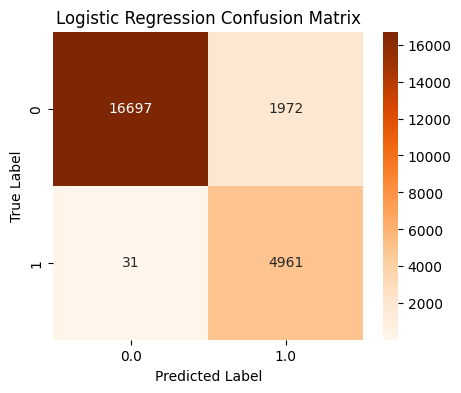

In [ ]:
conf_matrix_lr = predictions_lr.groupBy("label", "prediction").count().orderBy("label", "prediction")
conf_matrix_lr.show()
conf_matrix_pd_lr = conf_matrix_lr.toPandas().pivot(index='label', columns='prediction', values='count').fillna(0)

#Plotting confusion matrix for Logistic Regression
plt.figure(figsize=(5,4))
sns.heatmap(conf_matrix_pd_lr, annot=True, fmt="g", cmap="Oranges")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Logistic Regression Confusion Matrix")
plt.show()


### Confusion Matrix
* This matrix shows a distinct difference in performance compared to the Random Forest model.

* True Positives (4,961): The model is actually very good at catching Hot stars—slightly better than Random Forest (which had 4,890).

* False Negatives (31): It misses very few Hot stars.

* False Positives (1,972): This is the main weakness. The model incorrectly classifies nearly 2,000 Cool stars as Hot. This suggests the model is "aggressive" in predicting the minority class but lacks precision.

We use the Logistic Regression coefficients to interpret the influence of each feature on the prediction. Each coefficient shows how a one-unit change in the feature affects the log-odds of a star being classified as Hot versus Cool, while keeping other features constant. This helps understand which physical attributes—color, magnitude, or distance—drive the model’s decisions, making the model interpretable rather than just a black box.

In [25]:
coefficients = lr_model.coefficients
intercept = lr_model.intercept
print("\n>>> Logistic Regression Feature Coefficients:")
for i, col_name in enumerate(feature_cols):
    print(f"{col_name}: {coefficients[i]:.4f}")
print(f"Intercept: {intercept:.4f}")



>>> Logistic Regression Feature Coefficients:
bp_rp: -2.5534
phot_g_mean_mag: -0.5826
parallax: -0.0450
Intercept: 10.0268


This confirms that stellar color (bp_rp) is the dominant predictor of temperature, consistent with astrophysical expectations.

In [ ]:
# UDF to extract individual features from features vector
def get_feature(idx):
    return udf(lambda v: float(v[idx]), "double")

# Add original features back to LR predictions
pred_lr_plot = predictions_lr \
    .withColumn("bp_rp", get_feature(0)("features")) \
    .withColumn("phot_g_mean_mag", get_feature(1)("features"))

# Original test data (true labels)
test_plot_df = test_df \
    .withColumn("bp_rp", get_feature(0)("features")) \
    .withColumn("phot_g_mean_mag", get_feature(1)("features"))

# Convert both to Pandas
pred_lr_pd = pred_lr_plot.select("bp_rp", "phot_g_mean_mag", "prediction").toPandas()
test_pd = test_plot_df.select("bp_rp", "phot_g_mean_mag", "label").toPandas()


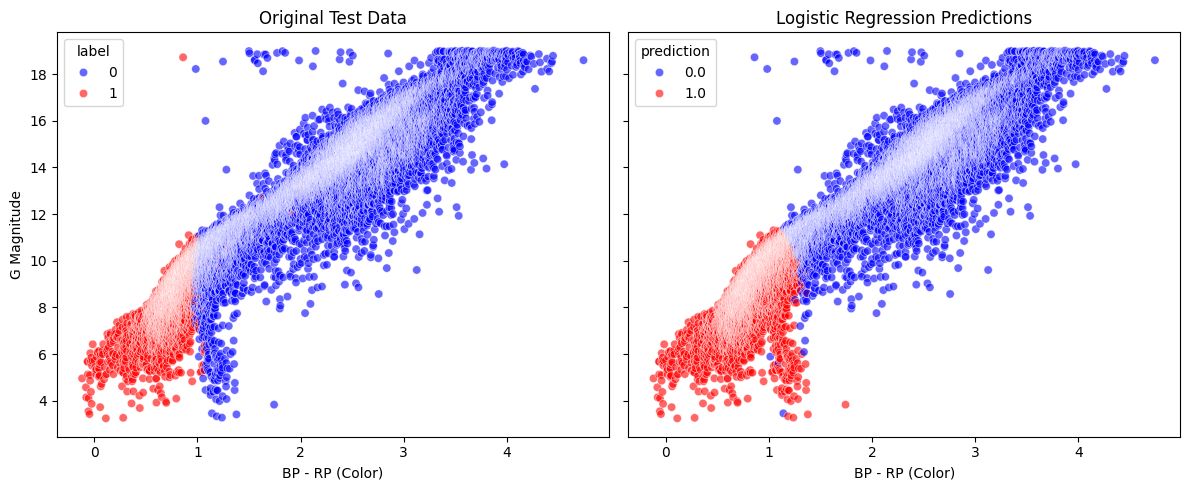

In [ ]:
# Plotting
fig, axes = plt.subplots(1, 2, figsize=(12,5), sharex=True, sharey=True)

# Original data
sns.scatterplot(
    ax=axes[0],
    data=test_pd,
    x="bp_rp",
    y="phot_g_mean_mag",
    hue="label",
    palette={0:"blue", 1:"red"},
    alpha=0.6
)
axes[0].invert_yaxis()
axes[0].set_title("Original Test Data")
axes[0].set_xlabel("BP - RP (Color)")
axes[0].set_ylabel("G Magnitude")

# Logistic Regression predictions
sns.scatterplot(
    ax=axes[1],
    data=pred_lr_pd,
    x="bp_rp",
    y="phot_g_mean_mag",
    hue="prediction",
    palette={0:"blue", 1:"red"},
    alpha=0.6
)
axes[1].invert_yaxis()
axes[1].set_title("Logistic Regression Predictions")
axes[1].set_xlabel("BP - RP (Color)")
axes[1].set_ylabel("G Magnitude")

plt.tight_layout()
plt.show()



### Predicted vs. Actual (HR Diagram)
The scatter plots below reveal why the Logistic Regression model struggled with False Positives.

* Left Plot (Original Data): The boundary between Hot (Red) and Cool (Blue) stars is slightly curved and complex.

* Right Plot (Logistic Regression Predictions): You can clearly see a straight line cutting through the data. Because Logistic Regression is a linear classifier, it is forced to draw a straight decision boundary. It cannot bend to fit the physical curve of the stellar main sequence, resulting in a large "wedge" of Cool stars being incorrectly painted Red (Hot) in the middle

# Random Forest Vs Logistic Regression

In [63]:
# Function to get class-wise metrics
def class_metrics(pred_df, model_name):
    rdd = pred_df.select("prediction", "label").rdd.map(lambda row: (float(row['prediction']), float(row['label'])))
    metrics = MulticlassMetrics(rdd)
    labels = sorted(rdd.map(lambda x: x[1]).distinct().collect())
    rows = []
    for label in labels:
        rows.append({
            "Class": int(label),
            "Precision": round(metrics.precision(label),4),
            "Recall": round(metrics.recall(label),4),
            "F1": round(metrics.fMeasure(label),4),
            "Model": model_name
        })
    return pd.DataFrame(rows)

metrics_rf_df = class_metrics(predictions, "Random Forest")
metrics_lr_df = class_metrics(predictions_lr, "Logistic Regression")

metrics_df = pd.concat([metrics_rf_df, metrics_lr_df], ignore_index=True)
print(">>> CLASS-WISE METRICS COMPARISON")
print(metrics_df)

/Users/jasmi/Library/CloudStorage/OneDrive-UniversityofEastLondon/CN6022-Big Data/CN6022_coursework/env/lib/python3.13/site-packages/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(
25/12/17 10:04:27 WARN DAGScheduler: Broadcasting large task binary with size 1960.6 KiB
25/12/17 10:04:27 WARN DAGScheduler: Broadcasting large task binary with size 1960.6 KiB
25/12/17 10:04:28 WARN DAGScheduler: Broadcasting large task binary with size 1966.6 KiB
25/12/17 10:04:29 WARN DAGScheduler: Broadcasting large task binary with size 1976.6 KiB


>>> CLASS-WISE METRICS COMPARISON
   Class  Precision  Recall      F1                Model
0      0     0.9945  0.9853  0.9899        Random Forest
1      1     0.9469  0.9796  0.9630        Random Forest
2      0     0.9981  0.8944  0.9434  Logistic Regression
3      1     0.7156  0.9938  0.8320  Logistic Regression


* Random Forest achieves very high performance on both classes, particularly maintaining strong precision and recall for the minority class (Hot stars, class 1).

* Logistic Regression performs well overall but struggles on the minority class, showing lower precision despite high recall.

* These metrics highlight how Random Forest better captures non-linear relationships, while Logistic Regression provides a simpler, interpretable linear model.

/var/folders/hm/23_snfxn18xd27tzlny1ymg40000gn/T/ipykernel_75297/1431111888.py:13: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


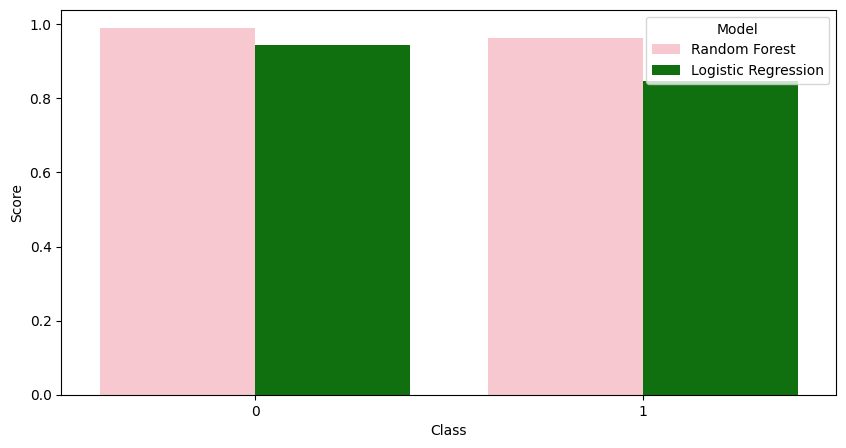

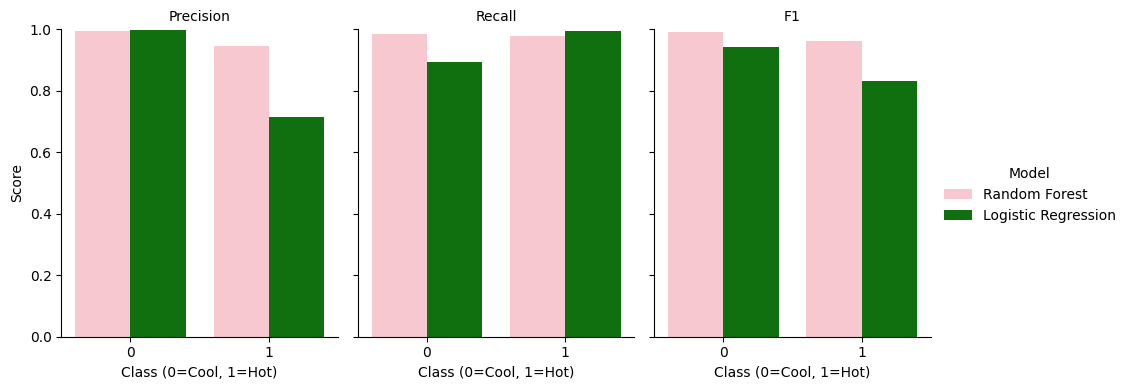

In [ ]:
# Melt the DataFrame for easy seaborn plotting
metrics_melted = metrics_df.melt(
    id_vars=["Class", "Model"], 
    value_vars=["Precision", "Recall", "F1"],
    var_name="Metric",
    value_name="Score"
)

plt.figure(figsize=(10,5))
sns.barplot(
    data=metrics_melted,
    x="Class",
    y="Score",
    hue="Model",
    palette={"Random Forest":"pink","Logistic Regression":"green"},
    ci=None
)

# Add facet for each metric
g = sns.catplot(
    data=metrics_melted,
    x="Class",
    y="Score",
    hue="Model",
    col="Metric",
    kind="bar",
    palette={"Random Forest":"pink","Logistic Regression":"green"},
    height=4,
    aspect=0.8
)

g.set_titles("{col_name}")
g.set_axis_labels("Class (0=Cool, 1=Hot)", "Score")
g.set(ylim=(0,1))
plt.show()


**Interpretation:** The plots visually reinforce the numerical class-wise metrics, showing that Random Forest handles the minority class better, while Logistic Regression is more prone to false positives for Hot stars.

Random Forest is the stronger model for both classes, but Logistic Regression provides a linear, interpretable baseline.

In [ ]:
# def get_feature(idx):
#     return udf(lambda v: float(v[idx]), "double")

# # Random Forest
# pred_rf_plot = predictions \
#     .withColumn("bp_rp", get_feature(0)("features")) \
#     .withColumn("phot_g_mean_mag", get_feature(1)("features"))

# # Logistic Regression
# pred_lr_plot = predictions_lr \
#     .withColumn("bp_rp", get_feature(0)("features")) \
#     .withColumn("phot_g_mean_mag", get_feature(1)("features"))

# # Convert to Pandas
# pred_rf_pd = pred_rf_plot.select("bp_rp", "phot_g_mean_mag", "label", "prediction").toPandas()
# pred_lr_pd = pred_lr_plot.select("bp_rp", "phot_g_mean_mag", "label", "prediction").toPandas()


25/12/17 09:24:35 WARN DAGScheduler: Broadcasting large task binary with size 1959.1 KiB


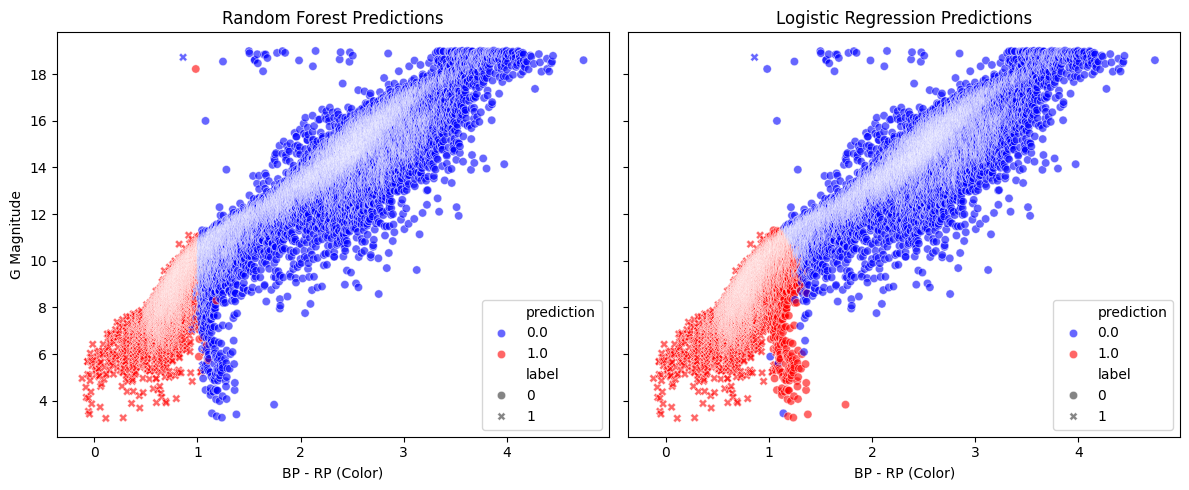

In [ ]:
#Plotting comparison
fig, axes = plt.subplots(1, 2, figsize=(12,5), sharex=True, sharey=True)

# Random Forest
sns.scatterplot(
    ax=axes[0],
    data=pred_rf_pd,
    x="bp_rp",
    y="phot_g_mean_mag",
    hue="prediction",      # predicted class
    style="label",         # true class
    palette={0:"blue", 1:"red"},
    alpha=0.6
)
axes[0].invert_yaxis()
axes[0].set_title("Random Forest Predictions")
axes[0].set_xlabel("BP - RP (Color)")
axes[0].set_ylabel("G Magnitude")

# Logistic Regression
sns.scatterplot(
    ax=axes[1],
    data=pred_lr_pd,
    x="bp_rp",
    y="phot_g_mean_mag",
    hue="prediction",      # predicted class
    style="label",         # true class
    palette={0:"blue", 1:"red"},
    alpha=0.6
)
axes[1].invert_yaxis()
axes[1].set_title("Logistic Regression Predictions")
axes[1].set_xlabel("BP - RP (Color)")
axes[1].set_ylabel("G Magnitude")

plt.tight_layout()
plt.show()


### Random Forest (Left):

**Non-Linearity:** The decision boundary (where red meets blue) is irregular and curved. It closely follows the natural, physical gap between the main sequence (cool stars) and the turn-off/giant branch (hot stars).

**Precision:** There is very little "bleeding" of red points into the blue region. The model respects the complex structure of the data.

### Logistic Regression (Right):

**Linearity:** The decision boundary is a distinct straight line.

**Misclassification:** Because the physical boundary of stellar populations is curved, the linear model cannot fit it perfectly. Notice the large "wedge" of blue stars (Cool) that are colored Red (predicted Hot) in the middle of the plot. These are the 1,972 False Positives identified in the confusion matrix earlier.

#### Conclusion: 

The Random Forest model is significantly better suited for this task because stellar classification on an HR diagram requires a non-linear decision boundary, which a simple linear classifier like Logistic Regression cannot provide.